In [1]:
%load_ext line_profiler
import matplotlib.pyplot as plt
%matplotlib inline
import numba
import numpy as np

# Simple Example of Gillespie Algorithm

a Birth-Death process loosely after Lennart Hilbert's example (https://lennarthilbert.com/2013/11/16/simple-example-of-gillespie-algorithm-in-matlab/)

## Model parameters

Constant production rate:

In [2]:
kk = 1.0

Destruction rate:

In [3]:
gamma = 0.1

## Simulation parameters

In [4]:
# Maximum number of reaction steps:

R_max = 1000

## The actual simulation

In [5]:
def birth_death_gillespie(kk, gamma, R_max):
    # containers for the simulation time course

    tt_cont = np.zeros(R_max+1)
    nn_cont = np.empty(R_max+1)

    # Definition of state changes for each reaction channel

    state_changes = np.array([+1.0,-1.0])

    # Pre-allocated propensity vector, no values yet

    aa = np.empty(2)

    

    tt_cont[0] = 0.0 # current time
    nn_cont[0] = 0 # current molecule count

    for R_counter in range(R_max):
        aa[0] = kk
        aa[1] = gamma * nn_cont[R_counter]

        # draw and record the waiting time
        delta_tt = np.random.exponential(1/aa.sum())


        # select reaction
        valid_inds = aa > 0
        valid_aa = aa[valid_inds]
        valid_changes = state_changes[valid_inds]

#         delta_nn = np.random.choice(valid_changes, p=valid_aa / valid_aa.sum())
        # an alternative to the slow choice above such that numba can work, inspired by Lennart again
        selection_interval = np.cumsum(valid_aa)
        selection_interval = selection_interval / selection_interval[-1]
        change_ind = np.nonzero(selection_interval > np.random.uniform(0, 1))[0][0]
        delta_nn = valid_changes[change_ind]

        # record
        tt_cont[R_counter+1] = tt_cont[R_counter] + delta_tt
        nn_cont[R_counter+1] = nn_cont[R_counter] + delta_nn
        
    return tt_cont, nn_cont

In [6]:
np.random.seed(42)
tt_cont, nn_cont = birth_death_gillespie(kk, gamma, R_max)

## Plot the result

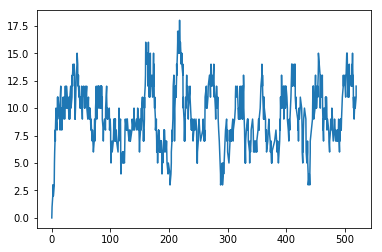

In [ ]:
np.random.seed(42)
plt.plot(tt_cont, nn_cont)

## Performance

In [ ]:
time_python = %timeit -o birth_death_gillespie(kk, gamma, R_max)

In [ ]:
lp = %lprun -r -f birth_death_gillespie birth_death_gillespie(kk, gamma, R_max)
lp.print_stats()

A lot of time is spent for drawing random numbers. This could possibly be optimised by drawing random numbers first (see Lennart's example)

## Does numba help?

In [ ]:
bdg_numba = numba.njit(birth_death_gillespie)

### Simulate

In [ ]:
tt_cont, nn_cont = bdg_numba(kk, gamma, R_max)

### Plot

In [ ]:
plt.plot(tt_cont, nn_cont)

### Performance

In [ ]:
time_numba = %timeit -o bdg_numba(kk, gamma, R_max)

## Compare python and numba

In [ ]:
time_python.average / time_numba.average

With numba the code runs 27 times faster! 

** Numba helps **